# Final Project: Predicting Customer Churn

This notebook demonstrates:
- Loading the Telco Customer Churn dataset automatically
- Exploratory Data Analysis (EDA)
- Data cleaning and preprocessing
- Baseline supervised learning models
- Evaluation and discussion

**Goal:** Predict whether a customer will churn (leave the service) based on demographic, account, and service usage data.

**Why it matters:** Churn prediction helps telecom companies retain customers by identifying at-risk clients and intervening early.

**Dataset:** Telco Customer Churn dataset (IBM sample)


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score


sns.set(style="whitegrid")
%matplotlib inline

DATA_PATH = "/home/jovyan/work/Telco_Churn_Dataset.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Clean the Data

In [16]:
# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Drop customerID
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

# Encode target
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn"])


# Exploratory Data Analysis# 

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


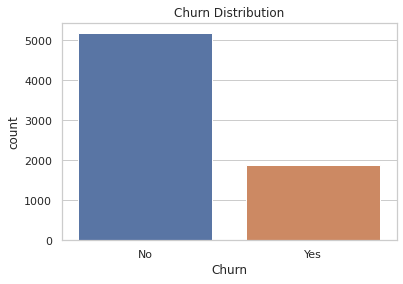

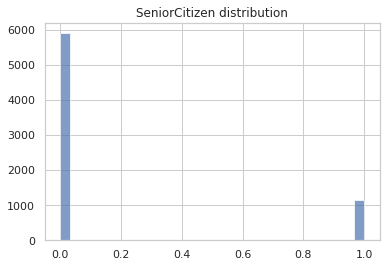

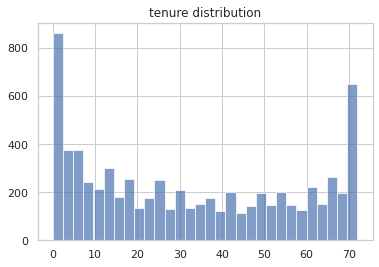

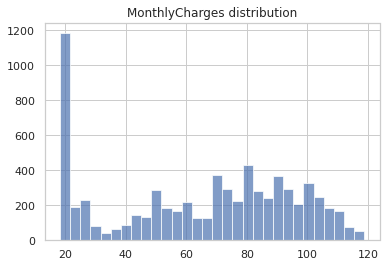

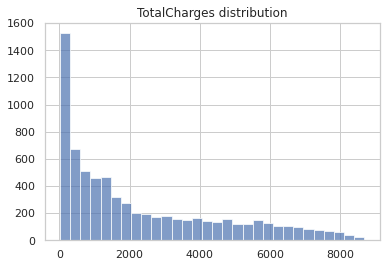

In [19]:
print(df.isna().sum())

sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=30, alpha=0.7)
    plt.title(f"{col} distribution")
    plt.show()



## Preprocessing


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


## Baseline Model: Logistic Regression


In [22]:
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

print("Logistic Regression")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.841468392363533


# Random Forest

In [23]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

ROC-AUC: 0.8223010152677672


# Support Vector Machine

In [26]:
svc = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", SVC(kernel="rbf", probability=True, random_state=42))
])

svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
y_proba_svc = svc.predict_proba(X_test)[:,1]

print("SVC")
print(classification_report(y_test, y_pred_svc))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_svc))


SVC
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC: 0.7904905835852127


# Cross-Validation Comparison

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in [("Logistic Regression", log_reg), ("Random Forest", rf), ("SVC", svc)]:
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    print(f"{name}: mean ROC-AUC={scores.mean():.3f}, std={scores.std():.3f}")


Logistic Regression: mean ROC-AUC=0.845, std=0.013
Random Forest: mean ROC-AUC=0.821, std=0.014
SVC: mean ROC-AUC=0.794, std=0.022


## Discussion and Conclusion

- Logistic Regression provides a strong baseline with interpretable coefficients.
- Random Forest improves performance and highlights feature importance.
- SVC captures nonlinear relationships but is slower to train.
- Key drivers of churn: contract type, tenure, monthly charges.
- Next steps: hyperparameter tuning, feature importance visualization, threshold optimization.


https://github.com/AbhiramL/Final_Project_IntroToMachineLearning.git